# Train Model with GPU (and CPU*)
CPU is used to store variables that we are learning (`W` and `b`) similar to a Parameter Server.  This allows the GPU to focus on compute vs. storage.

In [14]:
import tensorflow as tf
from tensorflow.python.client import timeline
import pylab
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.logging.set_verbosity(tf.logging.INFO)

## Reset TensorFlow Graph
Useful in Jupyter Notebooks

In [15]:
tf.reset_default_graph()

## Create TensorFlow Session

In [16]:
config = tf.ConfigProto(
  log_device_placement=True,
)
config.gpu_options.allow_growth=True
print(config)

sess = tf.Session(config=config)
print(sess)

gpu_options {
  allow_growth: true
}
log_device_placement: true



## Generate Model Version (current timestamp) 

In [17]:
from datetime import datetime 

version = int(datetime.now().strftime("%s"))

### Load Model Training and Test/Validation Data 


In [18]:
num_samples = 100000

[ 0.59715724  0.85000044  0.83802092 ...,  0.69240785  0.68908715
  0.38266236]
[ 0.33987491  0.37435064  0.39267895 ...,  0.36298379  0.37607841
  0.34513308]


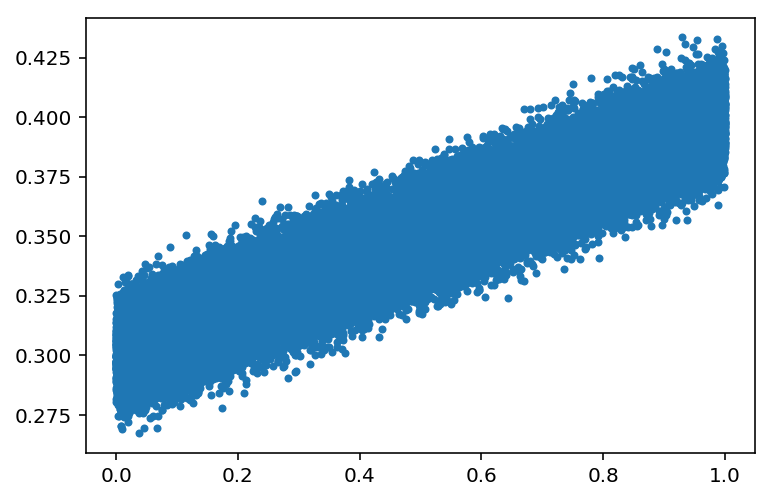

In [19]:
x_train = np.random.rand(num_samples).astype(np.float32)
print(x_train)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_train = x_train * 0.1 + 0.3 + noise
print(y_train)

pylab.plot(x_train, y_train, '.')

[ 0.93567061  0.89366055  0.30433723 ...,  0.3098183   0.84036046
  0.02901202]
[ 0.39090667  0.38389101  0.33654472 ...,  0.32687151  0.38192787
  0.30926563]


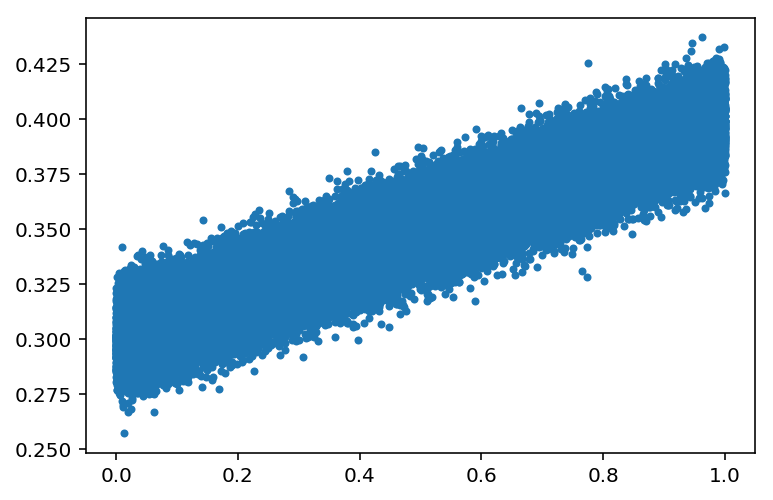

In [20]:
x_test = np.random.rand(len(x_train)).astype(np.float32)
print(x_test)

noise = np.random.normal(scale=.01, size=len(x_train))

y_test = x_test * 0.1 + 0.3 + noise
print(y_test)

pylab.plot(x_test, y_test, '.')

In [21]:
with tf.device("/cpu:0"):
    W = tf.get_variable(shape=[], name='weights')
    print(W)

    b = tf.get_variable(shape=[], name='bias')
    print(b)

with tf.device("/gpu:0"):            
    x_observed = tf.placeholder(shape=[None], 
                                dtype=tf.float32, 
                                name='x_observed')
    print(x_observed)

    y_pred = W * x_observed + b
    print(y_pred)

<tf.Variable 'weights:0' shape=() dtype=float32_ref>
<tf.Variable 'bias:0' shape=() dtype=float32_ref>
Tensor("x_observed:0", shape=(?,), dtype=float32, device=/device:GPU:0)
Tensor("add:0", shape=(?,), dtype=float32, device=/device:GPU:0)


In [22]:
learning_rate = 0.025

with tf.device("/gpu:0"):
    y_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='y_observed')
    print(y_observed)

    loss_op = tf.reduce_mean(tf.square(y_pred - y_observed))
    optimizer_op = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer_op.minimize(loss_op)  

    print("Loss Scalar: ", loss_op)
    print("Optimizer Op: ", optimizer_op)
    print("Train Op: ", train_op)

Tensor("y_observed:0", shape=(?,), dtype=float32, device=/device:GPU:0)
Loss Scalar:  Tensor("Mean:0", shape=(), dtype=float32, device=/device:GPU:0)
Optimizer Op:  <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7f3d08ef14e0>
Train Op:  name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_weights/ApplyGradientDescent"
input: "^GradientDescent/update_bias/ApplyGradientDescent"
device: "/device:CPU:0"



## Randomly Initialize Variables (Weights and Bias)
The goal is to learn more accurate Weights and Bias during training.

In [23]:
with tf.device("/cpu:0"):
    init_op = tf.global_variables_initializer()
    print(init_op)

name: "init"
op: "NoOp"
input: "^weights/Assign"
input: "^bias/Assign"
device: "/device:CPU:0"



In [24]:
sess.run(init_op)
print("Initial random W: %f" % sess.run(W))
print("Initial random b: %f" % sess.run(b))

Initial random W: 0.330155
Initial random b: 0.115316


## View Model Graph in Tensorboard

http://[ip-address]:6006

## View Accuracy of Pre-Training, Initial Random Variables
This should be relatively low.

In [25]:
def test(x, y):
    return sess.run(loss_op, feed_dict={x_observed: x, y_observed: y})

In [26]:
test(x_train, y_train)

0.0093838768

## Setup Loss Summary Operations for Tensorboard

In [27]:
loss_summary_scalar_op = tf.summary.scalar('loss', loss_op)
loss_summary_merge_all_op = tf.summary.merge_all()

In [28]:
train_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/gpu/%s/train' % version, 
                                            graph=tf.get_default_graph())

test_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/gpu/%s/test' % version,
                                            graph=tf.get_default_graph())

## Train Model

In [29]:
%%time

with tf.device("/gpu:0"):
    run_metadata = tf.RunMetadata()
    max_steps = 401
    for step in range(max_steps):
        if (step < max_steps - 1):
            test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
            train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train})
        else:  
            test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
            train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train}, 
                                            options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE), 
                                            run_metadata=run_metadata)

            trace = timeline.Timeline(step_stats=run_metadata.step_stats)    
            with open('gpu-timeline.json', 'w') as trace_file:
                trace_file.write(trace.generate_chrome_trace_format(show_memory=True))

        if step % 10 == 0:
            print(step, sess.run([W, b]))
            train_summary_writer.add_summary(train_summary_log, step)
            train_summary_writer.flush()
            test_summary_writer.add_summary(test_summary_log, step)
            test_summary_writer.flush()

0 [0.33093646, 0.11880334]
10 [0.33419663, 0.14479201]
20 [0.33218691, 0.16027908]
30 [0.32755852, 0.17024408]
40 [0.32168546, 0.17727709]
50 [0.31527805, 0.18272613]
60 [0.30870181, 0.18729377]
70 [0.30214316, 0.19134702]
80 [0.29569554, 0.19507845]
90 [0.28940427, 0.19858986]
100 [0.28328961, 0.20193598]
110 [0.27735907, 0.20514679]
120 [0.27161357, 0.20823954]
130 [0.26605061, 0.21122475]
140 [0.26066616, 0.21410933]
150 [0.25545534, 0.21689834]
160 [0.25041306, 0.21959586]
170 [0.24553412, 0.22220533]
180 [0.24081334, 0.22472985]
190 [0.23624568, 0.22717234]
200 [0.23182616, 0.22953549]
210 [0.22755, 0.23182194]
220 [0.2234126, 0.23403417]
230 [0.21940945, 0.23617461]
240 [0.21553616, 0.23824561]
250 [0.21178856, 0.24024938]
260 [0.20816256, 0.24218816]
270 [0.20465422, 0.24406402]
280 [0.20125967, 0.24587904]
290 [0.19797531, 0.24763514]
300 [0.19479747, 0.24933425]
310 [0.19172277, 0.25097826]
320 [0.18874782, 0.2525689]
330 [0.18586941, 0.25410795]
340 [0.18308437, 0.25559705]
3

(0, 1.0)

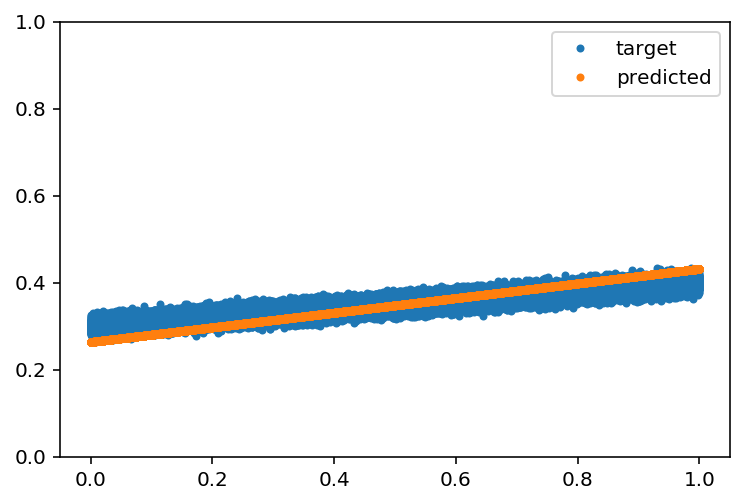

In [30]:
pylab.plot(x_train, y_train, '.', label="target")
pylab.plot(x_train, sess.run(y_pred, 
                             feed_dict={x_observed: x_train, 
                                        y_observed: y_train}), 
           ".", 
           label="predicted")
pylab.legend()
pylab.ylim(0, 1.0)

## View Loss Summaries in Tensorboard

Navigate to the Scalars tab at this URL:

http://[ip-address]:6006

## Save Model for Deployment and Inference

In [31]:
from tensorflow.python.saved_model import utils

tensor_info_x_observed = utils.build_tensor_info(x_observed)
print(tensor_info_x_observed)

tensor_info_y_pred = utils.build_tensor_info(y_pred)
print(tensor_info_y_pred)

name: "x_observed:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}

name: "add:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}



In [32]:
export_path = "/root/models/linear/gpu/%s" % version
print(export_path)

/root/models/linear/gpu/1494278888


In [33]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants

with tf.device("/cpu:0"):
    builder = saved_model_builder.SavedModelBuilder(export_path)

    prediction_signature =  signature_def_utils.build_signature_def(inputs = 
                            {'x_observed': tensor_info_x_observed}, 
                            outputs = {'y_pred': tensor_info_y_pred}, 
                            method_name = signature_constants.PREDICT_METHOD_NAME)

    legacy_init_op = tf.group(tf.initialize_all_tables(), name='legacy_init_op')

    builder.add_meta_graph_and_variables(sess, [tag_constants.SERVING],
                                         signature_def_map={'predict':prediction_signature, signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature}, 
                                         legacy_init_op=legacy_init_op)

    builder.save()

Instructions for updating:
Use `tf.tables_initializer` instead.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/root/models/linear/gpu/1494278888/saved_model.pb'


### View Saved Model on Disk

You must replace `[version]` with the version number from above ^^

In [ ]:
%%bash

# You must replace `[version]` with the version number from above ^^
ls -l /root/models/linear/gpu/[version]

## Save Graph For Optimization
We will use this later.

In [34]:
from tensorflow.python.framework import graph_io

graph_io.write_graph(sess.graph, 
                     "/root/models/optimize_me/", 
                     "unoptimized_gpu.pb")

'/root/models/optimize_me/unoptimized_gpu.pb'

In [ ]:
sess.close()